In [8]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from dask_ml.preprocessing import StandardScaler as dStandardScaler
from dask_ml.xgboost import XGBRegressor as dXGBRegressor
from dask_ml.model_selection import train_test_split as dtrain_test_split

In [2]:
pbar = ProgressBar()
pbar.register()

# Read Data

In [3]:
# keep only a subset of smart cols
CRITICAL_STATS = [1, 5, 7, 10, 187, 188, 190, 193, 197, 198, 241]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]
smart_cols = crit_cols_raw + crit_cols_normalized

keepcols = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure'] + smart_cols

In [4]:
# keep only seagate drives and only a small subset of columns
df = dd.read_parquet('../data/interim/data_Q3_2020_parquet', columns=keepcols)
df = df[df['model'].str.startswith('S')]
dd.compute(df.shape)

[########################################] | 100% Completed | 19.3s


((9398517, 27),)

In [5]:
df = df.set_index('date')

[########################################] | 100% Completed | 25.0s


In [6]:
dev_grouped_df = df.groupby('serial_number')

In [5]:
df['serial_number'].value_counts().compute()

[########################################] | 100% Completed | 43.6s


ZCH084PK    92
ZA16DWJA    92
ZA16DWRZ    92
ZA16DWS3    92
ZA16DWS9    92
            ..
ZCH0BS96     1
ZJV04W3M     1
ZCH0BDS0     1
ZJV00CZR     1
ZHZ4ESQP     1
Name: serial_number, Length: 109254, dtype: int64

In [17]:
device_df = df[df['serial_number']=='ZCH084PK'].compute()#.set_index('date')
dd.compute(device_df.shape)

[########################################] | 100% Completed | 24.0s


((92, 26),)

# plot all feats

In [33]:
device_df = device_df.set_index('date')

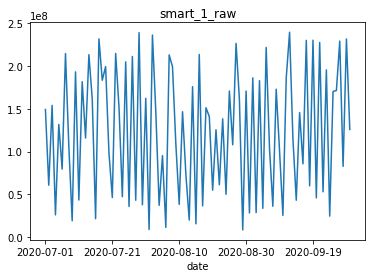

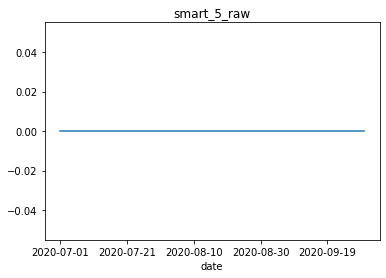

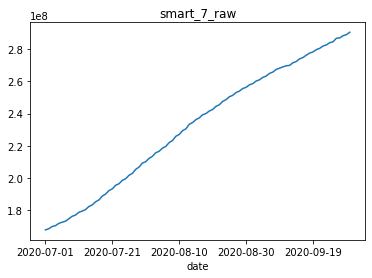

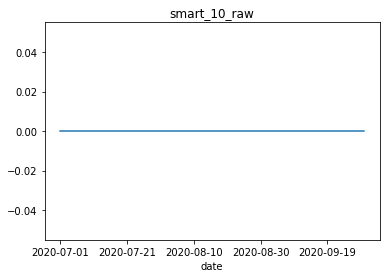

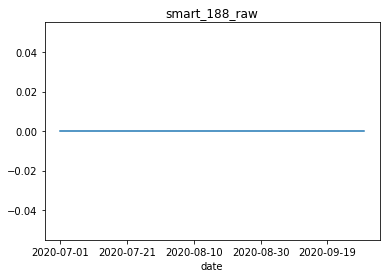

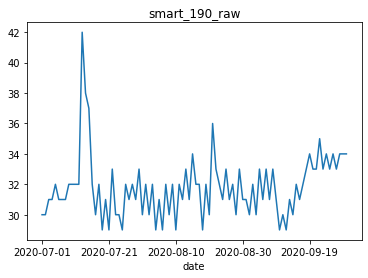

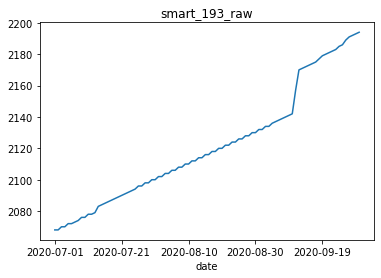

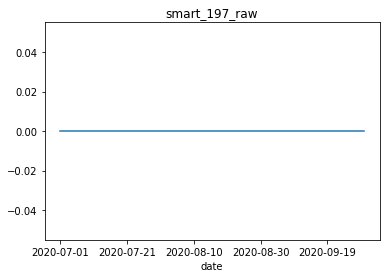

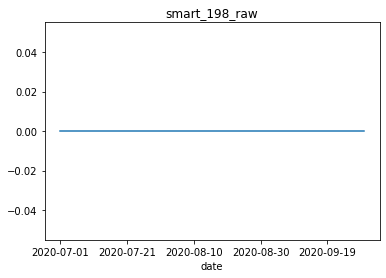

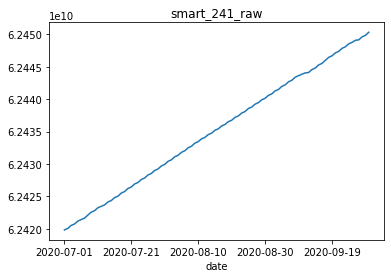

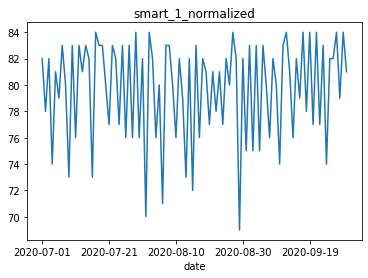

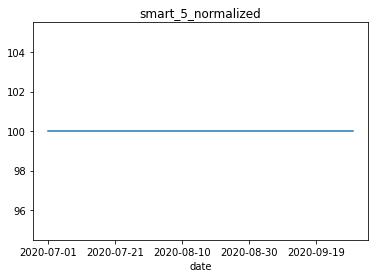

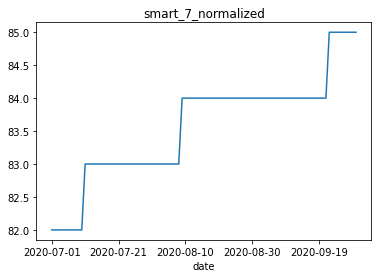

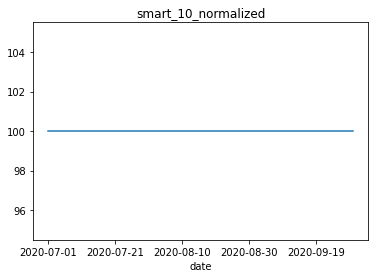

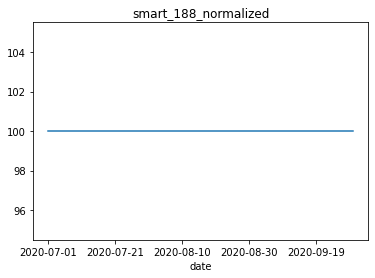

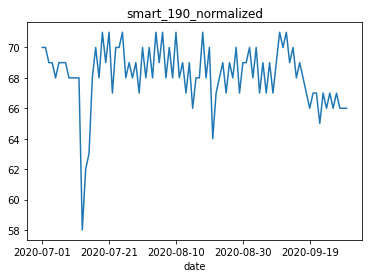

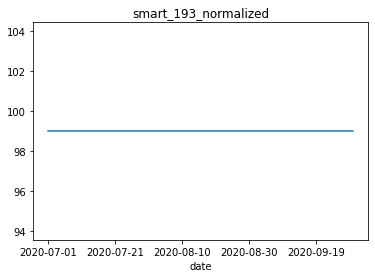

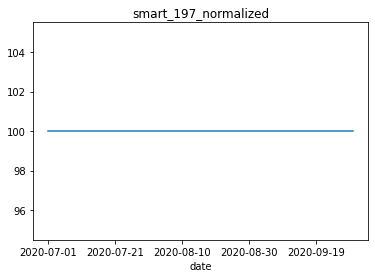

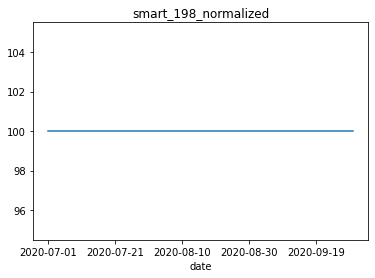

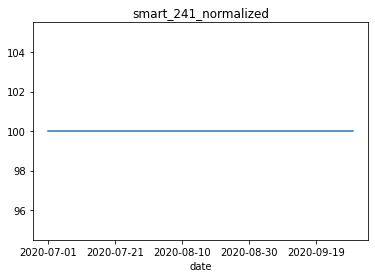

In [34]:
for col in x_cols:
    device_df[col].plot()
    plt.title(col)
    plt.show()

## ideas

- what do we want to predict?
    - given last 6 days of data, what would a metric look like tomorrow?
    - given last 6 days of data, what would a metric look like n days from today?

# Preprocess

In [24]:
y_col = 'smart_1_normalized'
x_cols = [i for i in smart_cols if i.split('_')[1]!=y_col.split('_')[1]]

In [25]:
NDAYS_DATA = 6

In [40]:
device_df

,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_10_raw,smart_187_raw,smart_188_raw,...,smart_5_normalized,smart_7_normalized,smart_10_normalized,smart_187_normalized,smart_188_normalized,smart_190_normalized,smart_193_normalized,smart_197_normalized,smart_198_normalized,smart_241_normalized
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,148970032.0,0.0,167845174.0,0.0,0.0,0.0,...,100.0,82.0,100.0,100.0,100.0,70.0,99.0,100.0,100.0,100.0
2020-07-02,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,60688536.0,0.0,168593648.0,0.0,0.0,0.0,...,100.0,82.0,100.0,100.0,100.0,70.0,99.0,100.0,100.0,100.0
2020-07-03,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,153774272.0,0.0,169927280.0,0.0,0.0,0.0,...,100.0,82.0,100.0,100.0,100.0,69.0,99.0,100.0,100.0,100.0
2020-07-04,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,26100192.0,0.0,170488633.0,0.0,0.0,0.0,...,100.0,82.0,100.0,100.0,100.0,69.0,99.0,100.0,100.0,100.0
2020-07-05,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,131608480.0,0.0,171876209.0,0.0,0.0,0.0,...,100.0,82.0,100.0,100.0,100.0,68.0,99.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,171225704.0,0.0,286651487.0,0.0,0.0,0.0,...,100.0,85.0,100.0,100.0,100.0,66.0,99.0,100.0,100.0,100.0
2020-09-27,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,228808176.0,0.0,286884243.0,0.0,0.0,0.0,...,100.0,85.0,100.0,100.0,100.0,67.0,99.0,100.0,100.0,100.0
2020-09-28,ZCH084PK,ST12000NM0007,1.200014e+13,0.0,82680376.0,0.0,288252396.0,0.0,0.0,0.0,...,100.0,85.0,100.0,100.0,100.0,66.0,99.0,100.0,100.0,100.0


In [ ]:
xdf = device_df[x_cols]
y_df = device_df[y_col]

In [43]:
input_scaler = StandardScaler()
target_scaler = StandardScaler()

adaboost_regr = AdaBoostRegressor()
randomforest_regr = RandomForestRegressor()

In [82]:
preds = [None]*len(device_df)
for i in range(len(device_df) - NDAYS_DATA):
    x = input_scaler.fit_transform(device_df[x_cols].iloc[i: i+NDAYS_DATA+1])
    y = target_scaler.fit_transform(device_df[[y_col]].iloc[i: i+NDAYS_DATA+1])
    
    adaboost_regr.fit(
        x[:NDAYS_DATA], 
        y[:NDAYS_DATA].ravel(),
    )
    preds[i+NDAYS_DATA] = target_scaler.inverse_transform(
        adaboost_regr.predict(x[-1, np.newaxis])
    )[0]
preds = pd.Series(preds, index=device_df.index)
preds

date
2020-07-01     NaN
2020-07-02     NaN
2020-07-03     NaN
2020-07-04     NaN
2020-07-05     NaN
              ... 
2020-09-26    74.0
2020-09-27    82.0
2020-09-28    82.0
2020-09-29    79.0
2020-09-30    84.0
Length: 92, dtype: float64

In [83]:
preds.head(10)

date
2020-07-01     NaN
2020-07-02     NaN
2020-07-03     NaN
2020-07-04     NaN
2020-07-05     NaN
2020-07-06     NaN
2020-07-07    79.0
2020-07-08    83.0
2020-07-09    80.0
2020-07-10    73.0
dtype: float64

In [87]:
y_true = device_df[y_col]

In [92]:
sklearn.metrics.mean_squared_error(preds.iloc[NDAYS_DATA+1:], y_true.iloc[NDAYS_DATA+1:])

30.49411764705882

In [37]:
xtrain = device_df[x_cols].iloc[:train_idx]
xtest = device_df[x_cols].iloc[train_idx:]
ytrain = device_df[y_col].iloc[:train_idx]
ytest = device_df[y_col].iloc[train_idx:]

In [54]:
scaler = StandardScaler()
scaler.fit(xtrain)

StandardScaler()

In [57]:
# reg = LinearRegression().fit(scaler.transform(xtrain), ytrain)
# reg = GradientBoostingRegressor().fit(scaler.transform(xtrain), ytrain)
reg = RandomForestRegressor().fit(scaler.transform(xtrain), ytrain)
# reg = AdaBoostRegressor().fit(scaler.transform(xtrain), ytrain)
reg.score(scaler.transform(xtest), ytest)

-0.4312366954022966

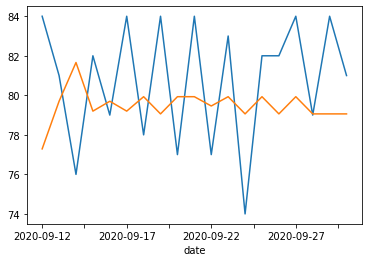

In [58]:
ytest.plot()
plt.plot(xtest.index, reg.predict(scaler.transform(xtest)))
plt.show()

# Cleanup

In [ ]:
# pbar.unregister()